In [2]:
using ControlSystemsBase, MonteCarloMeasurements, RobustAndOptimalControl, Plots, ControlSystemIdentification
unsafe_comparisons(true)

┌ Info: Unsafe comparisons using the function `pmean` has been enabled globally. Use `@unsafe` to enable in a local expression only or `unsafe_comparisons(false)` to turn off unsafe comparisons
└ @ MonteCarloMeasurements /Users/uchytada/.julia/packages/MonteCarloMeasurements/A5hvx/src/MonteCarloMeasurements.jl:73


false

## Exercise 1 - Hard-disk drive

Your goal is to control the read/write head assembly of a hard disk drive. Position control of the head assembly can be divided into two regimes: seeking and tracking regime. During the seeking regime, the head moves from one data track to another one; as the time is crucial here, time-optimal controllers are usually used for control in this regime. During the tracking regime, the goal is to keep the head as close as possible to a given data track. Thus, the control system of read/write head assembly switches between two controllers depending on whether the goal is to track or to change a data track. Here, you will tackle only the tracking regime.
We will skip the details and jump right into it. This is the transfer function of the model:

$$
    G(s) = \frac{1}{s^2}\frac{2\frac{\zeta}{\omega}s + 1}{\frac{1}{\omega^2}s^2 + \frac{2\zeta}{\omega}s + 1}
$$
where damping $\zeta$ and frequency $\omega$  are uncertain. We can model this uncertainty using `MonteCarloMeasurements` as

In [41]:
ω = 4..12
ζ = 0.054..0.084

0.069 ± 0.00866 Particles{Float64, 2000}


which also allows us to define an uncertain system:



In [42]:
G  = tf([2*ζ/ω, 1],  [1/ω^2, 2*ζ/ω, 1, 0, 0]) |> ss

StateSpace{Continuous, Particles{Float64, 2000}}
A = 
 -1.1 ± 0.35  -8.67 ± 4.7  0.0  0.0
  8.0          0.0         0.0  0.0
  0.0          4.0         0.0  0.0
  0.0          0.0         2.0  0.0
B = 
 1.0
 0.0
 0.0
 0.0
C = 
 0.0  0.0  0.0345 ± 0.011  1.08 ± 0.58
D = 
 0.0

Continuous-time state-space model

Now, we were given a simple filtered PD controller and we would like to know whether it is robustly stabilizing for the system above. The controller is given by

In [44]:
C = 1.0 * tf([1, 1], [0.1, 1]) |> ss

StateSpace{Continuous, Float64}
A = 
 -10.0
B = 
 8.0
C = 
 -11.25
D = 
 10.0

Continuous-time state-space model

and the closed-loop system is given by

In [45]:
T = feedback(C*G, 1)

StateSpace{Continuous, Particles{Float64, 2000}}
A = 
 -10.0   0.0          0.0          0.276 ± 0.087    8.67 ± 4.7
  11.2  -1.1 ± 0.35  -8.67 ± 4.7  -0.345 ± 0.11   -10.8 ± 5.8
   0.0   8.0          0.0          0.0              0.0
   0.0   0.0          4.0          0.0              0.0
   0.0   0.0          0.0          2.0              0.0
B = 
 0.0
 1.0
 0.0
 0.0
 0.0
C = 
 -11.2  0.0  0.0  0.345 ± 0.11  10.8 ± 5.8
D = 
 0.0

Continuous-time state-space model

Let's look at the step response of the closed-loop system. We will use the `step` function from the `ControlSystems` package. 

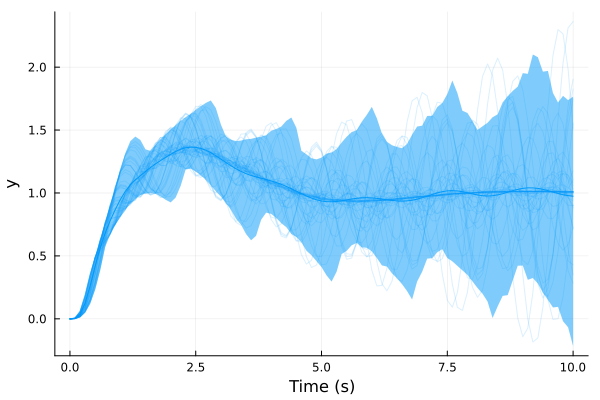

In [47]:
plot(step(T, 0:0.1:10))

The `step` function simulated the system for a range of parameters, and just by looking at the plot we can see that for some parameters the system is unstable. Let's check the stability more fomally. Specifically, let's model the uncertainty as a multiplicative uncertainty and check the stability of the closed-loop system using the robust stability criterion 

$$
    \lvert T(j\omega) \rvert \leq \frac{1}{\lvert W(j\omega) \rvert}\;, \forall \omega \in \mathbb{R},
$$
where $T$ is the closed-loop transfer function and $W$ is a shaping filter modeling the uncertainty. The filter should

$$
    \frac{\lvert G_0(j\omega) - G(j\omega) \rvert}{\lvert G_0(j\omega) \rvert} \leq \lvert W(j\omega) \rvert,
$$
where $G_0$ is the nominal system and $G$ is the uncertain system. Let's try to construct such a filtert. We will by measuring a series of frequency responses for different values of $\zeta$ and $\omega$, and construct the filter a upperbound on the relative error with respect to the nominal system.

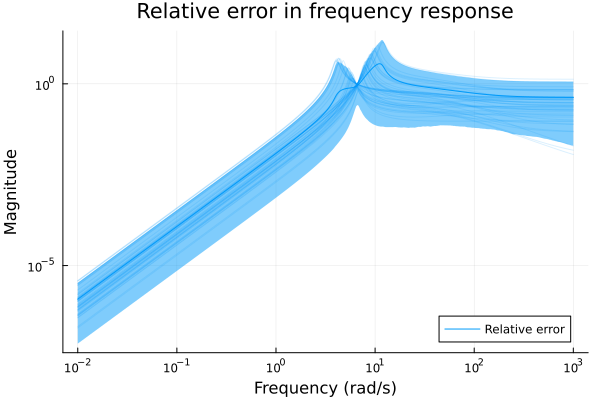

In [48]:
ωs = exp10.(-2:0.01:3)

f_resp_nominal = freqresp(nominal(G), ωs)[:]
f_resp_perturbed = freqresp(G, ωs)[:]

err = (f_resp_nominal - f_resp_perturbed ) ./ f_resp_nominal
plot(ωs, abs.(err), label="Relative error", xlabel="Frequency (rad/s)", ylabel="Magnitude", title="Relative error in frequency response", legend=:bottomright, xaxis=:log, yaxis=:log, xticks = exp10.(-2:1:3))

Compute the envelope of the frequency response:

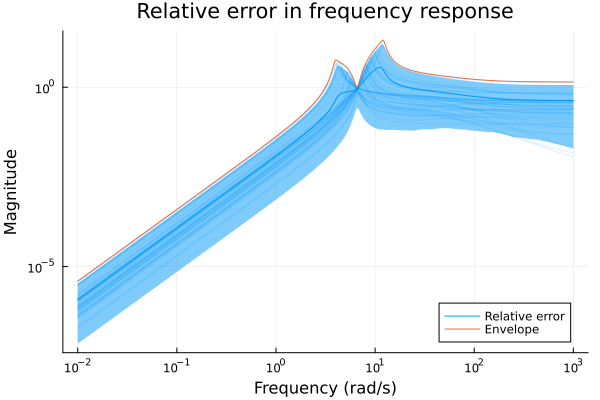

In [49]:
envelope =  pmaximum.(abs.(err))
plot!(ωs, envelope, label="Envelope", xlabel="Frequency (rad/s)", ylabel="Magnitude", title="Relative error in frequency response", legend=:bottomright, xaxis=:log, yaxis=:log)

We now have the envelope as a series of points without any explicit parametrization. We can try to fit a filter to the envelope. We are gonna look for a filter of the form

$$
    W(s) = k\frac{s^2 + 2\zeta_z \omega_z s + \omega_z^2}{s^2 + 2\zeta_p \omega_p s + \omega_p^2}
$$

In [50]:
using JuMP, Ipopt
model = Model(Ipopt.Optimizer)
@variable(model, k >= 0)
@variable(model, ωp >= 0)
@variable(model, ζp >= 0)
@variable(model, ωz >= 0)
@variable(model, ζz >= 0)

H2(w) =  k^2 * ((ωz^2 - w^2)^2 + (2*ζz*ωz*w)^2) / ((ωp^2 - w^2)^2 + (2*ζp*ωp*w)^2) 

obj = 0
for (k, ω) in enumerate(ωs)
    @constraint(model, 1/2 * log10(H2(ω)) >= log10(envelope[k]))
    obj += (1/2 * log10(H2(ω)) - log10(envelope[k]))^2
end
@objective(model, Min, obj)
optimize!(model)


ωp_opt = value(ωp)
ζp_opt = value(ζp)
ωz_opt = value(ωz)
ζz_opt = value(ζz)

k_opt = value(k)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     2505
Number of nonzeros in Lagrangian Hessian.............:     7530

Total number of variables............................:        5
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      501
        inequality constraints with only lower bounds:      501
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1808808e+03 3.32e+00 1.77e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

13.55752652541626

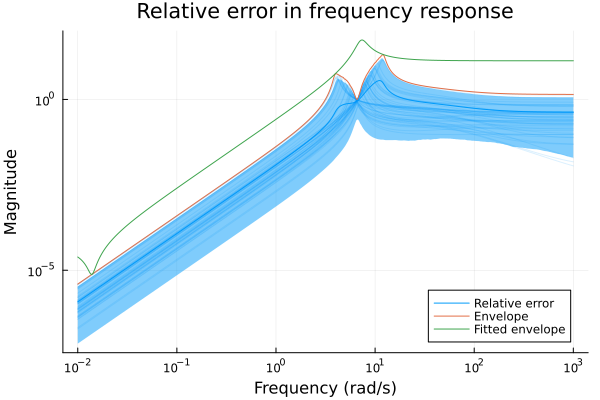

In [51]:
W = k_opt * tf([1, 2*ζz_opt*ωz_opt, ωz_opt^2], [1, 2*ζp_opt*ωp_opt, ωp_opt^2]) |> ss
f_resp_weight = freqresp(W, ωs)[:]
plot!(ωs, abs.(f_resp_weight), label="Fitted envelope", xlabel="Frequency (rad/s)", ylabel="Magnitude", title="Relative error in frequency response", legend=:bottomright, xaxis=:log, yaxis=:log, xticks = exp10.(-2:1:3))

After we fitted the filter, let's check the stability of the closed-loop system. We can do that by ploting the frequency response of the closed-loop system and the filter's inverse.

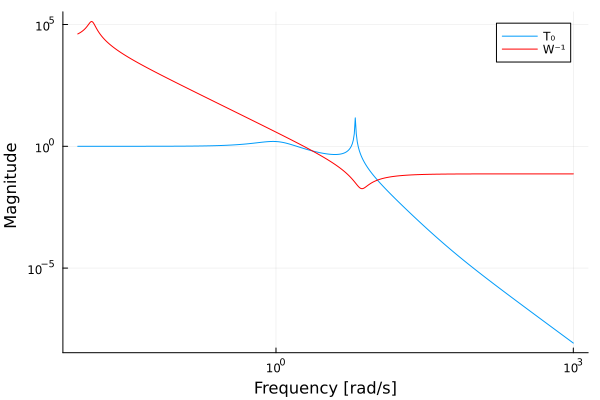

In [59]:
bodeplot(nominal(T), ωs,  plotphase=false, label="T₀")
bodeplot!(inv(W), ωs, plotphase=false, label="W⁻¹", color=:red)

For some frequencies, the closed-loop frequency response is larger than the filter's inverse. This means that the closed-loop system is not robustly stable. We can try to modify the controller to make the system robustly stable, e.g, by decreasing its gain.

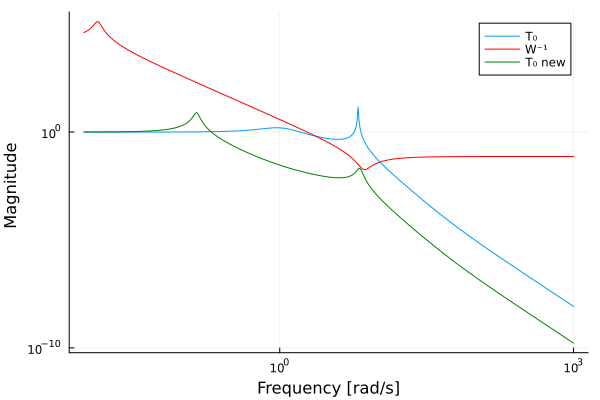

In [60]:
C_new = 0.02 * tf([1, 1], [0.1, 1]) |> ss 
T_new = feedback(C_new*G, 1)
bodeplot!(feedback(C_new*nominal(G), 1), ωs, plotphase=false, label="T₀ new", color=:green)

Now, the closed-loop system is actually under the filter's inverse for all frequencies. This means that the closed-loop system is robustly stable. We can also check the step response of the closed-loop system to see how it behaves.

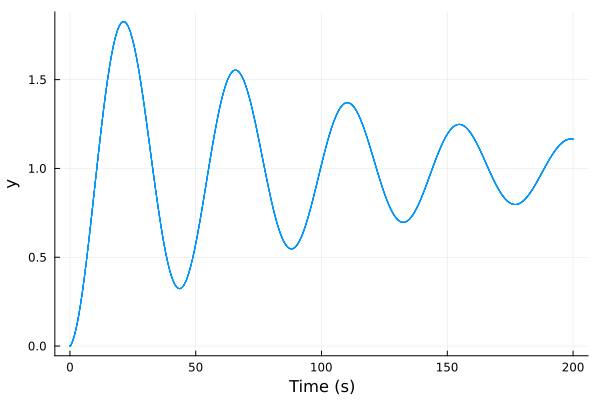

In [61]:
plot(step(feedback(C_new*G, 1), 0:0.1:200))

It seems that the system is no longer exploding for some parameters, but we slowed down the system's response immensely. Is there a better way of tuning the controller? The answer is yes, and it's called $H_\infty$ loop shaping. We will do this in the next exercise, however, here's a little sneak peek of what it looks like. 

In [62]:
WS = makeweight(1e4, 0.01, 0.5)
WT = W
WU = 1e-3ss(1)

z, p, k = zpkdata(nominal(G)) # Shift the poles at the origin to left 
p[1][end] -= Complex(1e-4)
p[1][end-1] -= Complex(1e-4)
Ĝ = zpk(z, p, k) |> ss

P = hinfpartition(Ĝ, WS, WU, WT)
hinfassumptions(P, verbose=true)

K, γ = hinfsynthesize(P, γrel = 0.8)

All assumtions are satisfied!


(StateSpace{Continuous, Float64}
A = 
 -16117.955684710241  -145567.07522215694  -2.6752022025627927e6    -2.288594081488005e7     1.0887994365029281e7  -2.3532052821194544e7    3.234393984135505e6
      8.0                   0.0             0.0                      0.0                     0.0                    0.0                     0.0
      0.0                   2.0             0.0                      0.0                     0.0                    0.0                     0.0
      0.0                   0.0             2.0                      0.0                     0.0                    0.0                     0.0
      0.0                   0.0            -2.0816681711721685e-17  -6.661338147750939e-16  -7.071067756600984e-5   9.548571745142219e-17   3.498510571062299e-16
      0.0                   0.0             0.41639377499999997     10.830681                0.0                   -1.8015010765834845     -6.592839039378672
      0.0                   0.0             0.0   

Now, let's check the stability of the closed-loop system again. We can do that by ploting the frequency response of the closed-loop system and the filter's inverse.

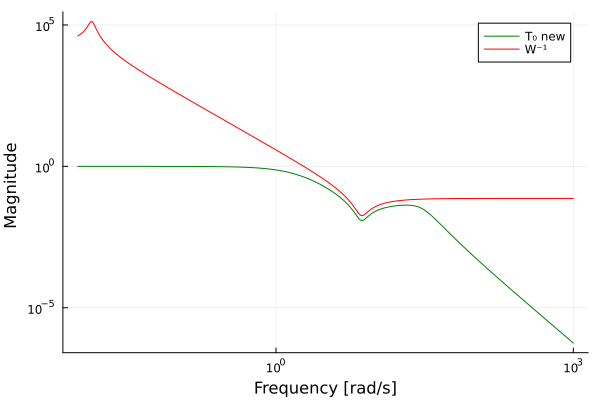

In [63]:
T_new = feedback(nominal(G)*K, 1)

bodeplot(nominal(T_new), ωs, plotphase=false, label="T₀ new", color=:green)
bodeplot!(inv(W), ωs, plotphase=false, label="W⁻¹", color=:red)

The freqency response of the closed-loop is almost perfectly fit to the filter's inverse. This means that the closed-loop system is robustly stable, without sacrificing the performance. We can confirmed that by observing the step response of the closed-loop system. The system is stable and has a good performance.

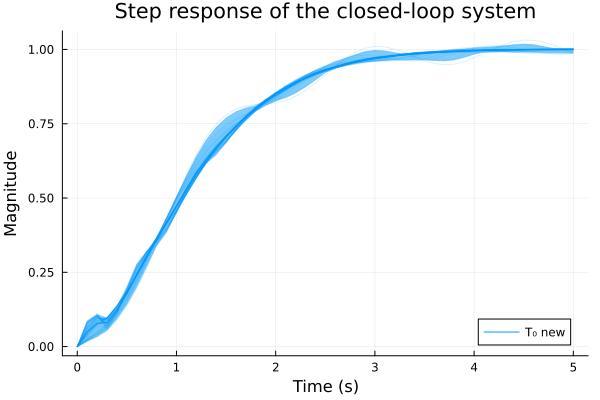

In [64]:
T_new = feedback(K*G,1)

plot(step(T_new, 0:0.1:5), label="T₀ new", xlabel="Time (s)", ylabel="Magnitude", title="Step response of the closed-loop system", legend=:bottomright)

## Exercise 2 - Servo system

Your task is to design a robust controller for an unceratin model of a DC motor. The DC motor is modeled by the following state-space model:

$$
\begin{align*}
L \frac{di}{dt} &= -Ri  -k\omega + u,\\
J \frac{d\omega}{dt} &= -b\omega + k i
\end{align*}
$$

with parameters

In [40]:
L = 30e-3
R = 3.4
k = 0.0425..0.0575
J = 0.005..0.02

0.0125 ± 0.00433 Particles{Float64, 2000}
